In [25]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

from surprise import Dataset
from surprise import Reader
from surprise import NMF

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Ponemos una semilla fija para que el experimento sea reusable
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

# Calculo Factorización de Matrices

En este notebook entrenaremos la factorización de matrices aplicando el algoritmo **NMF**. Una vez entrenado, ya tendremos la matriz $P$ (relaciona usuario con las dimensiones) y la matriz $Q$ (relaciona películas con dimensiones). Al final, en la carpeta `data/matrices_data` tendremos la matriz $Q_u$ de cada usuario. Esto es la matriz $Q$ multiplicada por el vector en $P$ de cada usuario.

# Preparar dataset

Separaremos los datos de los ratings en 2 grupos, entrenamiento (que tendrá el 90% de los datos) y evaluación (que tendrá el 10% de los datos).

In [26]:
def train_test_split(dataDF, training_percentage):
    '''
    Función que divide el dataset en un conjunto de entrenamiento y
    otro conjunto de evaluación.
    '''
    msk = np.random.rand(len(dataDF)) < float(training_percentage / 100)
    train = dataDF[msk]
    test = dataDF[~msk]
    
    return train, test    

In [27]:
# Cargamos todos los ratings del experimento
ratings_DF = pd.read_csv('data/experiment_data/ratings.csv')
ratings_DF.head()

,userId,movieId,rating,timestamp
0,6,10,3.0,845553253
1,6,32,4.0,845553426
2,6,34,4.0,845553354
3,6,47,4.0,845553317
4,6,50,1.0,845553381


In [28]:
# Calculamos el porcentaje de la matriz completado

num_users = len(ratings_DF.groupby('userId').count().index)
num_items = len(ratings_DF.groupby('movieId').count().index)
total_ratings = len(ratings_DF)
total_values_to_predict = num_users * num_items

print(100*(total_ratings / total_values_to_predict), '% ratings conocidos del total de la matriz')

62.23 % ratings conocidos del total de la matriz


In [29]:
# Preparamos el dataset de entrenamiento y evaluación
trainset, testset = train_test_split(ratings_DF, 90)

# Guardamos ambos dataframes en CSV
trainset.to_csv('data/experiment_data/trainset.csv', index=False)
testset.to_csv('data/experiment_data/testset.csv', index=False)

## Entrenamiento del algoritmo

Del nuevo dataset que hemos creado, calculamos las matrices P y Q usando el algoritmode NMF definido en la librería surprise.

In [30]:
# Cargamos los datasets
trainset_DF = pd.read_csv('data/experiment_data/trainset.csv', usecols=[0,1,2])
testset_DF = pd.read_csv('data/experiment_data/testset.csv', usecols=[0,1,2])

# Preparamos los datos de entrenamiento y evaluación

reader = Reader(rating_scale=(1,5))

train_data = Dataset.load_from_df(trainset_DF, reader).build_full_trainset()
test_data = Dataset.load_from_df(testset_DF, reader).build_full_trainset().build_testset()

# Seleccionamos el algoritmo
recommendation_algorithm = NMF()

# Entrenamos el algoritmo
recommendation_algorithm.fit(train_data)

# Obetenmos las predicciones
predictions = recommendation_algorithm.test(test_data)

# Mostramos las predicciones
predictions_df = pd.DataFrame(predictions, columns=['userId', 'movieId', 'realRating', 'estRating', 'details']).drop(columns='details')
predictions_df.head()

,userId,movieId,realRating,estRating
0,6,165,3.0,4.043745
1,6,296,2.0,4.417548
2,6,377,5.0,3.889263
3,6,588,5.0,4.028946
4,18,1,3.5,4.002399


## Calculamos las matrices $Q_u$

A continuación, calculamos las matrices $Q_u$ de cada usuario y lo guardamos en ficheros CSV.

In [31]:
# Obtenemos las matrices P y Q
p = pd.DataFrame(recommendation_algorithm.pu)
p['userId'] = sorted(list(set(trainset_DF['userId'])))
p.set_index('userId',inplace=True)
p.reset_index(inplace=True)

q = recommendation_algorithm.qi

In [32]:
# Por cada usuario calculamos su Qu y la gaurdamos en un CSV

for u in tqdm(range(len(p))):
    user_id = int(p.loc[u]['userId'])
    user_vector = p.loc[u][1:].values

    q_u = user_vector * q
    q_u_df = pd.DataFrame(q_u)
    q_u_df['movieId'] = sorted(list(set(trainset_DF['movieId'])))
    q_u_df.set_index('movieId', inplace=True)
    q_u_df.reset_index(inplace=True)
    
    path = 'data/matrices_data/q_user_' + str(user_id) + '.csv'
    q_u_df.to_csv(path, index=False)

100%|██████████| 100/100 [00:00<00:00, 188.85it/s]


## Visualizar matrices

En esta sección se pueden visualizar las matrices $Q_u$. Se muestra un mapa de calor de la matriz y un analisis estádistico de cada uno de los factores de la matriz $Q_u$. 

In [33]:
# Seleccionar el usuario que vamos a mostrar
user_id = 462
path = 'data/matrices_data/q_user_' + str(user_id) + '.csv'

In [34]:
q_u_DF = pd.read_csv(path)
q_u_DF.head()

,movieId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1,0.790610,0.011947,0.470114,0.524623,0.080660,0.063912,0.072636,0.027964,0.425497,0.326641,0.281329,0.023851,0.031188,0.006435,0.003104
1,10,0.455114,0.019879,0.735871,0.207420,0.008381,0.098625,0.119952,0.446306,0.265782,0.004934,0.034952,0.205391,0.218134,0.016112,0.071825
2,32,0.247699,0.051980,0.147124,0.130595,0.053603,0.012985,0.274659,0.312372,0.255779,0.157096,0.088003,0.081117,0.172477,0.015475,0.066068
3,34,0.537087,0.004056,0.855386,0.008162,0.164839,0.005903,0.311529,0.113476,0.332327,0.259938,0.085276,0.423715,0.113675,0.020730,0.052446
4,47,0.404275,0.009336,0.671679,0.476981,0.020292,0.119584,0.248646,0.311539,0.151067,0.247855,0.205020,0.156516,0.178361,0.015632,0.036482


In [35]:
q_u_describe = q_u_DF.describe()
q_u_describe

,movieId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3516.910000,0.400625,0.025562,0.388655,0.229847,0.095087,0.090503,0.213357,0.230364,0.223510,0.212832,0.269156,0.180287,0.121685,0.012508,0.050388
std,10221.919625,0.211278,0.012849,0.210858,0.119142,0.051411,0.041816,0.099030,0.122403,0.102450,0.098513,0.139694,0.097879,0.066410,0.005894,0.024160
min,1.000000,0.001051,0.001586,0.035174,0.003536,0.000188,0.002956,0.010989,0.002000,0.003085,0.004934,0.031500,0.003257,0.002855,0.001200,0.000889
25%,474.250000,0.255394,0.014931,0.211985,0.142571,0.060179,0.064018,0.147444,0.120920,0.156808,0.140891,0.168746,0.113486,0.075595,0.008286,0.031721
50%,1194.500000,0.397566,0.024488,0.371216,0.225685,0.094077,0.092458,0.224254,0.224339,0.219801,0.202937,0.263927,0.181332,0.114425,0.012267,0.052742
75%,2727.500000,0.557256,0.033506,0.529242,0.317252,0.133434,0.117092,0.275764,0.326821,0.276751,0.267534,0.361036,0.235898,0.159762,0.016083,0.068359
max,79132.000000,0.863888,0.053341,0.985346,0.524623,0.236191,0.199339,0.475324,0.499656,0.539835,0.440411,0.751469,0.423715,0.416954,0.027015,0.101362


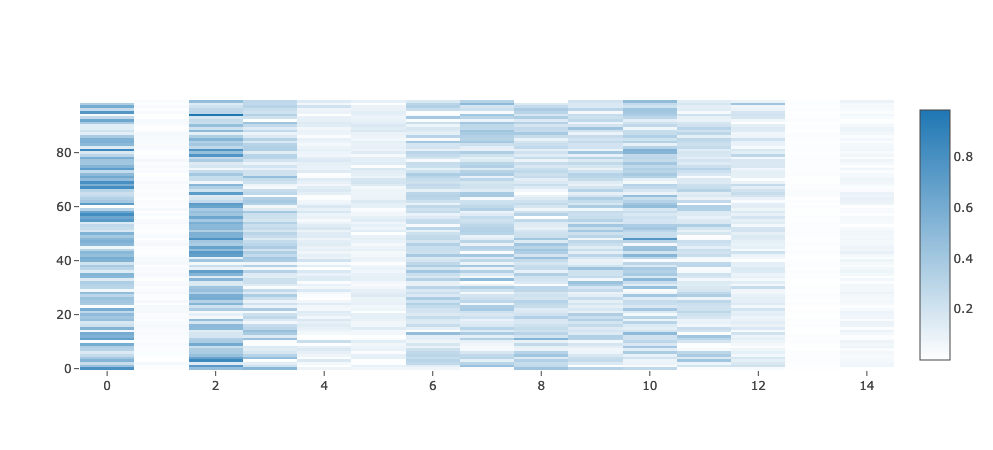

In [36]:
trace = go.Heatmap(z=q_u_DF.iloc[:,1:].values,
                   x=q_u_DF.columns[1:].values,
                   y=q_u_DF.index.values,
                   colorscale=[[0.0, 'rgb(255,255,255)'], [1.0, 'rgb(31, 119, 180)']])

data=[trace]
iplot(data, filename='labelled-heatmap')

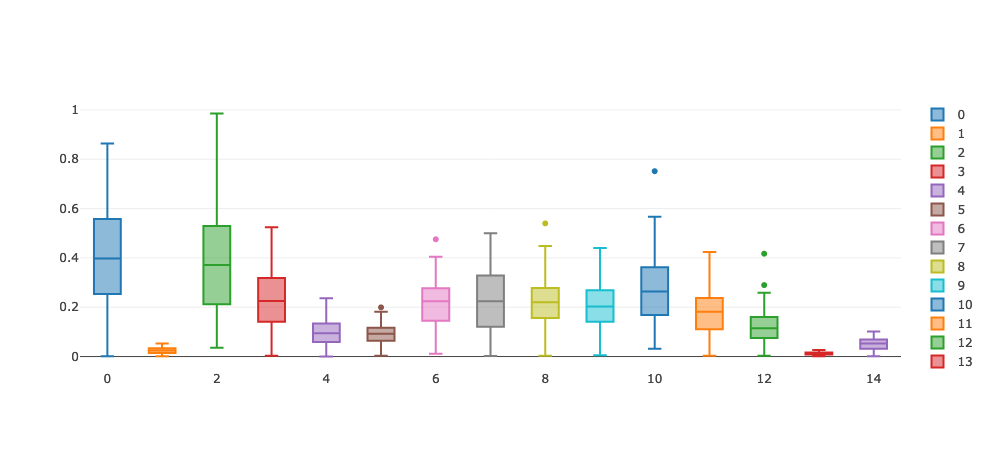

In [37]:
aux = q_u_DF.drop(columns=['movieId']).transpose()
data = []
for i in range(len(aux)):
    trace = go.Box(
        y = aux.iloc[i,:].values,
        name = str(i)
    )

    data.append(trace)

iplot(data)

### Siguiente Notebook

Una vez calculado las matrices $Q$ por cada usuario ya podemos obtener películas similares a partir de esa información y estudiar las características en común. Ejecute el notebook `recomendador_con_explicaciones.ipynb`.